# Yelp Restaurant Exploration
## Introduction
A person's choice in dining has always been so subjective.  Each of has own our preferences and biases when it comes to food, and so the phrase "Where should we eat?" has launched countless debates and stalled decisions.  Yelp has offerred us a solution to that age-old debate. Crowd-consensus has provided us with objective evidence that this restaurant here is truly the one for us.

But how much can we truly learn from crowd-consensus?  Is a five-star restaurant with 10 reviews truly the better choice over a four-star with 500?  Are there any features about a restaurant that we might use to predict how it might be rated?  In this project, I'll explore these questions.

## The Dataset
[Yelp and Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) have partered to provide us with an extensive dataset around Yelp's primary experiences - business information, user profiles, reviews, tips, and check-ins.   The data is organized into six .json files with over 5,000,000 entries between them.  However, in this project we will only focus on one - [yelp_academic_dataset_business.json](yelp_academic_dataset_business.json), which contains information on over 174,000 business in 11 metropolitan areas.

## Questions to Answer
- What is the distribution of star ratings for restaurants on Yelp?
- Does a restaurant's rating really tell us it's the right choice? How does the number of reviews factor into a rating?
- Using the attributes attached to a restaurant, how well can we predict its star rating?

In [1]:
# Import required packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from ast import literal_eval
from matplotlib.patches import Ellipse
from pandas.io.json import json_normalize

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

%matplotlib inline

## First Look

The data set includes information on a wide spectrum of businesses, but as true foodies, we are really only interested in the restaurants.  We'll have to isolate these from the data set, but let's first take a look at the general structure.


In [2]:
file = "D:\Directory\what_makes_a_hotspot\data\yelp_academic_dataset_business.json"
raw = pd.read_json(file, lines=True)
raw.head(1)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ


In [3]:
raw.dtypes

address          object
attributes       object
business_id      object
categories       object
city             object
hours            object
is_open           int64
latitude        float64
longitude       float64
name             object
postal_code      object
review_count      int64
stars           float64
state            object
dtype: object

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192609 entries, 0 to 192608
Data columns (total 14 columns):
address         192609 non-null object
attributes      163773 non-null object
business_id     192609 non-null object
categories      192127 non-null object
city            192609 non-null object
hours           147779 non-null object
is_open         192609 non-null int64
latitude        192609 non-null float64
longitude       192609 non-null float64
name            192609 non-null object
postal_code     192609 non-null object
review_count    192609 non-null int64
stars           192609 non-null float64
state           192609 non-null object
dtypes: float64(3), int64(2), object(9)
memory usage: 20.6+ MB


## Isolating Restaurants
We've found a golf course in Phoenix, Arizona, which apparently is not good for kids.  We can see that it has a unique identifier called `business_id`, and that the `attributes` and `categories` fields contain nested data.  We will have to get at this data in our exploration.

We can also see that we have pretty good coverage throughout the fields.  `hours`, `attributes`, and `categories` contain varying amounts of missing fields.  This will need to be accounted for, as well.  Let's first try to isolate our restaurants.

In [5]:
def retrieve_restaurants(file):
    """
    Iterate over JSON file and funnel restaurants to a dataframe for analysis
    """
    # Retrieve JSONReader generator
    reader = pd.read_json(file, lines=True, chunksize=1000)
    
    # Define empty dataframe for storing matches
    cols = ['address', 'attributes', 'business_id', 'categories', 'city', 'latitude', 'longitude', 
            'name', 'postal_code', 'review_count', 'stars', 'state', 'restaurant']
    
    restaurants = pd.DataFrame(columns=cols)
    
    # Iterate over chunks, and funnel matches into dataframe
    for chunk in reader:
        
        chunk["restaurant"] = chunk["categories"].apply(lambda x:
            "Restaurants" in x.replace(" ", "").split(",") if x is not None else False
        )
        
        restaurants = pd.concat([restaurants, chunk[chunk["restaurant"]]], sort=True)
    
    # Set index to business_id
    restaurants.set_index("business_id", inplace=True)
        
    return restaurants

In [6]:
restaurants = retrieve_restaurants(file)
restaurants.head(1)

,address,attributes,categories,city,hours,is_open,latitude,longitude,name,postal_code,restaurant,review_count,stars,state
business_id,,,,,,,,,,,,,,
QXAEGFB4oINsVuTFxEYKFQ,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1.0,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,True,128,2.5,ON


In [7]:
restaurants.head(1)['attributes'].values[0]

{'RestaurantsReservations': 'True',
 'GoodForMeal': "{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': False, 'breakfast': False}",
 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
 'Caters': 'True',
 'NoiseLevel': "u'loud'",
 'RestaurantsTableService': 'True',
 'RestaurantsTakeOut': 'True',
 'RestaurantsPriceRange2': '2',
 'OutdoorSeating': 'False',
 'BikeParking': 'False',
 'Ambience': "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}",
 'HasTV': 'False',
 'WiFi': "u'no'",
 'GoodForKids': 'True',
 'Alcohol': "u'full_bar'",
 'RestaurantsAttire': "u'casual'",
 'RestaurantsGoodForGroups': 'True',
 'RestaurantsDelivery': 'False'}

## Parsing and Cleaning

Now we're talking.  Dim sum in Mississa-something!  Ouch on the 2.5 stars though.  At least there's a full bar.

Digging in to the `attributes` column, we see there is a wealth of information - the type of meals a restaurant is good for, ambience, alcohol service, noise level, even wifi availability!  Some fields like `Ambience` even have their own nested dictionaries.  In order to properly analyze this set, we'll need to normalize these attributes into our dataframe.

In [8]:
def parse_nested(x):
    """
    Assist in removing some of the artifacts preventing clean parsing of nested data
    """
    
    if x is None:
        return '{"None": True}'
    elif x == "None":
        return '{"None": True}'
    else:
        return x
    
def normalize_nested(df, col):
    """
    Clean a nested column within the attributes field, convert from string to a dictionary, and normalize to fit the data set
    """
    
    norm = df["attributes"].apply(lambda x: x.get(col) if x is not None else '{"None": 1}')
    
    norm = norm.apply(parse_nested)
    
    norm = norm.apply(literal_eval)
    
    norm = json_normalize(norm).set_index(df.index)
    
    for c in norm.columns:
        # Rename columns with prefix
        new_name = col.lower()+"_"+c
        norm.rename(columns={c: new_name}, inplace=True)
        
        # Set True/False to 1/0
        norm[new_name] = norm[new_name].apply(lambda x: 1 if x is True else 0)
        
    norm.fillna(0, inplace=True)
    
    return df.merge(norm, left_index=True, right_index=True)

def parse_attributes(df):
    """
    Parse attribute fields that do not contain nested data and remove unicode artifacts
    """
    
    # Selected Attributes
    attr = ["NoiseLevel", "RestaurantsTableService", "RestaurantsTakeOut", "OutdoorSeating", "Alcohol", 
            "RestaurantsAttire", "RestaurantsDelivery", "RestaurantsGoodForGroups", "GoodForKids"]

    for a in attr:
        
        col = a.lower()
        
        # Set as column
        df[col] = df["attributes"].apply(lambda x: x.get(a) if x is not None else 0)
        
        # Remove unicode references
        df[col] = df[col].str.replace("u'", "").str.replace("'", "")
                
    return df
    
def parse_dummies(df):
    """
    Parse string columns in Attributes field and convert to dummy variables
    """
    
    # Dummy columns
    dummies = ["noiselevel", "alcohol", "restaurantsattire"]

    for d in dummies:
        
        # Get dummies and merge on dataframe
        df = df.merge(pd.get_dummies(df[d], prefix=d), left_index=True, right_index=True)
        
    return df

def format_restaurants(df):
    """
    Normalized nested field, parse attributes, and create dummy columns where necessary.  Remove 
    columns that are extraneous to our analysis, and ensure all fields are either integer or float.
    """
    
    # Normalize Ambience columns
    df = normalize_nested(df, "Ambience")
    
    # Normalize GoodForMeal columns
    df = normalize_nested(df, "GoodForMeal")
    
    # Parse attribute columns
    df = parse_attributes(df)
    
    # Parse dummies
    df = parse_dummies(df)
    
    # Drop extraneous columns
    drop_cols = ['attributes', 'noiselevel', 'alcohol', 'restaurantsattire', 'address', 'categories', 
                 'city', 'latitude', 'longitude', 'name', 'postal_code', 'state', 'restaurant', 'hours',
                 'is_open', 'ambience_None', 'goodformeal_None', 'noiselevel_None', 'alcohol_None',
                 'restaurantsattire_None']
    
    df.drop(columns=drop_cols, inplace=True)
    
    # Set review_count to int
    df["review_count"] = df["review_count"].astype(int)
    
    # If column is still an object, set values to binary
    for col in df.columns:
        if df[col].dtype in [object, bool]:
            df[col] = df[col].apply(lambda x: 1 if x == 'True' else 0)
    
    return df

In [9]:
clean = format_restaurants(restaurants)
clean.head(1)

,review_count,stars,ambience_casual,ambience_classy,ambience_divey,ambience_hipster,ambience_intimate,ambience_romantic,ambience_touristy,ambience_trendy,...,noiselevel_average,noiselevel_loud,noiselevel_quiet,noiselevel_very_loud,alcohol_beer_and_wine,alcohol_full_bar,alcohol_none,restaurantsattire_casual,restaurantsattire_dressy,restaurantsattire_formal
business_id,,,,,,,,,,,,,,,,,,,,,
QXAEGFB4oINsVuTFxEYKFQ,128,2.5,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0


## Cleaned Data
Wow! That was a lot of work!  There were a few eccentricities in the attributes field that required some extra attention.  Mainly, some of the nested dictionaries were inconsistently formatted, which required some additional parsing logic.  Regardless, we now have a normalized dataset with dummy variables for many of the nested items within the attributes field.  Our data is also now entirely numeric, which should make the next analysis steps much smoother.

## Distribution of Star Ratings

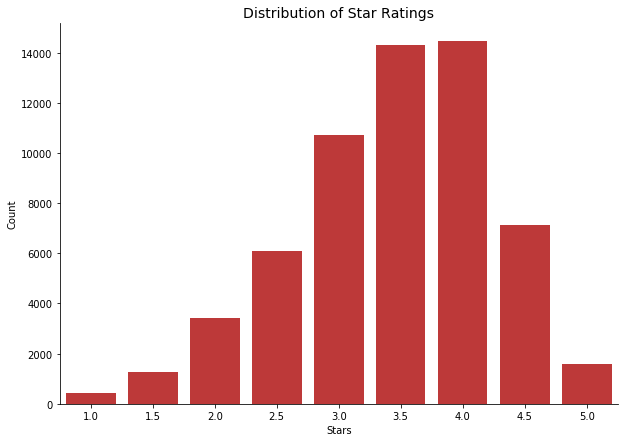

In [10]:
# Instantiate Figure
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Create countplot
sns.countplot(clean.stars, color='#d32323', ax=ax)

# Format
ax.set_title("Distribution of Star Ratings", fontsize=14)
ax.set_xlabel("Stars")
ax.set_ylabel("Count")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

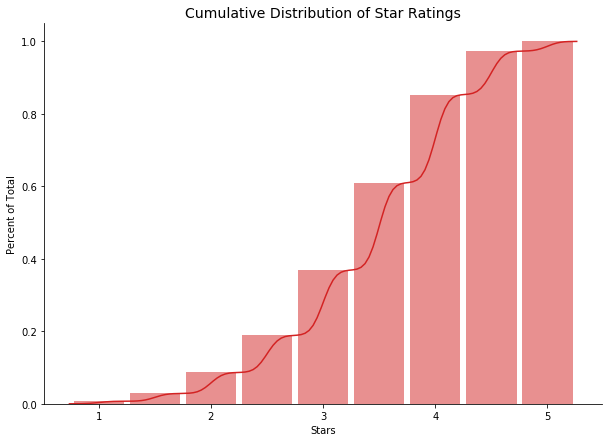

In [11]:
# Instantiate Figure
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Create distplot
sns.distplot(clean.stars, color='#d32323', bins=[1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5],
             hist_kws={'cumulative': True, 'align': 'left', 'rwidth': .9, "alpha": 0.5}, 
             kde_kws={'cumulative': True}, ax=ax)

# Format
ax.set_title("Cumulative Distribution of Star Ratings", fontsize=14)
ax.set_xlabel("Stars")
ax.set_ylabel("Percent of Total")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

The distribution of star ratings appears to be slightly skewed towards higher ratings, though fives remain relatively rare.  It seems Yelp reviewers trend towards the "good, but not great" view on most restaurants - at least in the cities we have available to us.  Looking at the cumulative distribution chart, we can see just about 60% of reviews fall at 3.5 stars or less.

## The Impact of Review Count

But let's dive a bit deeper and see how review count factors in.  Do we see restaurants with a higher number of reviews regress towards the mean of rating? Are there some that resist the pull towards the center?

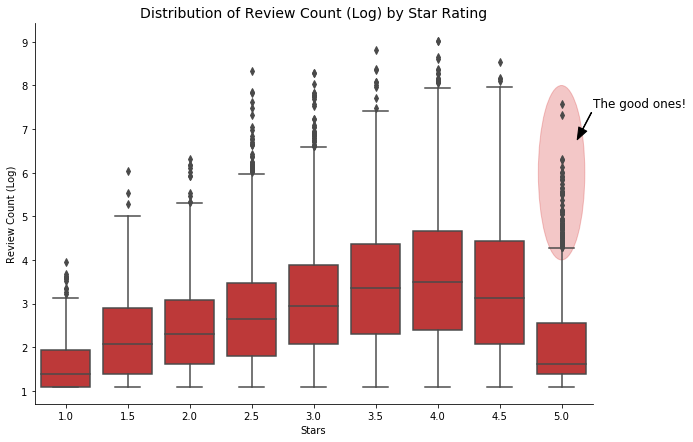

In [12]:
# Instantiate Figure
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Create boxplot
sns.boxplot(x=clean["stars"], y=np.log(clean["review_count"]), ax=ax, color='#d32323')

# Draw elipse
ellipse = Ellipse((8, 6), .75, 4, alpha=0.25, color='#d32323')
ax.add_artist(ellipse)

# Add annotation
ax.annotate('The good ones!', xy=(8.25,6.75), xytext=(8.5,7.5), fontsize=12,
           arrowprops=dict(facecolor='black', shrink=0.01, width=0.5, headwidth=9))

# Format
ax.set_title("Distribution of Review Count (Log) by Star Rating", fontsize=14)
ax.set_xlabel("Stars")
ax.set_ylabel("Review Count (Log)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

Interesting!  We can see our middle-of-the-pack restaurants typically have a higher count of reviews than those on the edges.  One star reviewed restaurants have the least reviews.  This might be from bad reviews driving other Yelpers away, or it could just be that nobody posts a review for the McDonald's on Exit 73 unless they've had a really bad experience.  Five star reviewed restaurants have the second-lowest count, though we see a long tail of outliers that may prove interesting.  Note, the log of review counts was taken here to diminish the impact of outlier restaurants with thousands of reviews.

## Proposing a New Metric

So we see that five-star restaurants typically have smaller review counts than those in the middle of the pack.  What does that tell us?  Can we really trust a rating when only five reviews have been entered?  Wouldn't the 4.5 star restaurant with one hundred reviews be a much safer choice?

The concept of weighted scoring has been brought up by Yelpers before, but usually to the tune of reactions like this -

![Imgur](https://i.imgur.com/7KSEkcw.png)

Fortunately, the folks at [math.stackexchange](https://math.stackexchange.com/questions/942738/algorithm-to-calculate-rating-based-on-multiple-reviews-using-both-review-score) operate more on my frequency and offered the following formula for producing a weighted score -

$$\text{score}=Pp+10(1-P)(1-e^{-q/Q}))$$

To paraphrase, we can combine the notions of quality ($p$ for star rating) and quantity ($q$ for review count) by assigning each of them weights and normalizing onto a similar scale. $P$ becomes the weight (between 0 and 1) we assign to our star rating.  The review count becomes embedded in an exponential function with it's own weight, $Q$; and the output of this is multipled by the inverse of star's $P$ along with the constant $10$ make our score function on a nice 1 to 10 scale.  We add these together to get our weighted rating!

Got that?  I recommend reading [the post](https://math.stackexchange.com/questions/942738/algorithm-to-calculate-rating-based-on-multiple-reviews-using-both-review-score) again.  It took me a few times as well.  Anywho, without further ado, let's introduce our restaurant heatscore™!

## Heatscore!™

In [13]:
def calculate_heatscore_tm(x, p, q):
    
    return (p * x["stars"]) + (10*(1 - p) * (1 - np.exp(-(x["review_count"])/q)))
    

clean["heatscore"] = clean.apply(calculate_heatscore_tm, axis=1, args=(0.7, 140))

clean.sort_values("heatscore", ascending=False).head(15)[["review_count", "stars", "heatscore"]]

,review_count,stars,heatscore
business_id,,,
Xg5qEQiB-7L6kGJ5F4K3bQ,1936,5.0,6.499997
IhNASEZ3XnBHmuuVnWdIwA,1506,5.0,6.499936
SSCH4Z2gw-hh2KZy7aH4qw,552,5.0,6.441822
ewmTwsZqCHH2gvCeDKz0dw,543,5.0,6.437959
q2GzUNQj998GSC8IhkN9hg,459,5.0,6.386954
1qkKfqhO8z2XMzLLDFE96Q,414,5.0,6.344098
52yWGkwnrQXIjvuMjYxsiA,402,5.0,6.330146
8fFTJBh0RB2EKG53ibiBKw,374,5.0,6.292540
3pSUr_cdrphurO6m1HMP9A,363,5.0,6.275582


With the heatscore™ applied, we can see our top restaurants remain those with five stars.  However, around entry thirteen, we start to see the 4.5 star restaurants with very high volumes of reviews. Our formula appears to be working!  Let's play with the parameters a bit to see how they impact the scoring.

In [14]:
def plot_heatscore_tm(df, p, q):

    # Instantiate Figure
    fig, ax = plt.subplots(3, 3, figsize=(12, 10), sharex=True, sharey=True)

    x, y = 0, 0
    for star in np.sort(df["stars"].unique()):

        star_df = df[df["stars"]==star]

        ax[x][y].scatter(np.log(star_df["review_count"]), star_df["heatscore"], color='#d32323', s=1)

        ax[x][y].set_title(str(star) + " Stars")

        if y == 2:
            x += 1
            y = 0
        else:
            y += 1

    # Set common labels
    fig.text(0.5, 0.075, 'Review Count (Log)', ha='center', va='center', fontsize=12)
    fig.text(0.09, 0.5, 'Heatscore™', ha='center', va='center', rotation='vertical', fontsize=12)
    fig.suptitle(f"Heatscore™ Comparison by Star Review\nP={p}, Q={q}", y=.96, fontsize=14)

    plt.show()

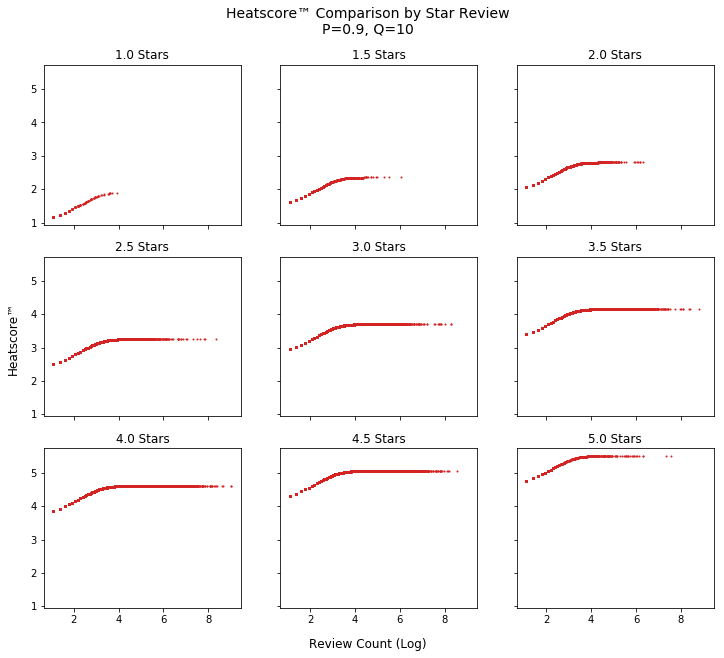

In [15]:
p, q = 0.9, 10

heatscore = clean
heatscore["heatscore"] = heatscore.apply(calculate_heatscore_tm, axis=1, args=(p, q))
plot_heatscore_tm(heatscore, p, q)

A very high $P$ and a low $Q$ results in a scoring that's fairly close to the standard ratings.  Low star ratings are penalized severly, while high ratings get a huge boost.  Large review counts provide some boost, but not really enough to lift them above restaurants with a higher star review.

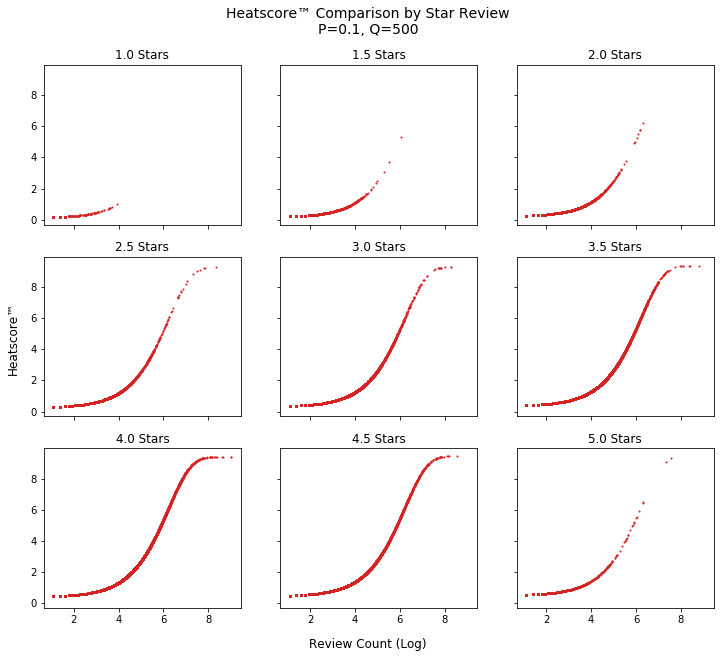

In [16]:
p, q = 0.1, 500

heatscore1 = clean
heatscore1["heatscore"] = heatscore1.apply(calculate_heatscore_tm, axis=1, args=(p, q))
plot_heatscore_tm(heatscore1, p, q)

Taken to the other extreme, a low $P$ and large $Q$ all but removes the influence of star scores.  Even very poorly rated restaurants can acheive high scores if their review counts are large.  Let's try to find a happy medium.

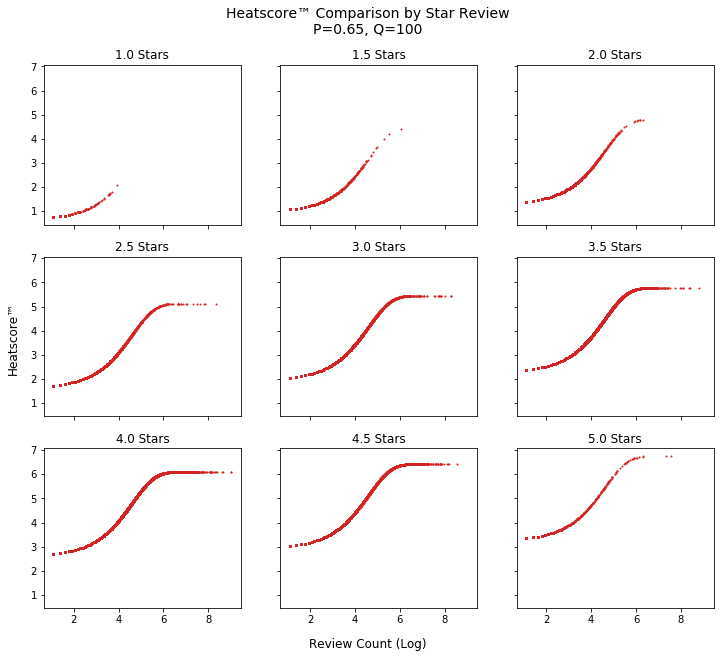

In [17]:
p, q = 0.65, 100

heatscore2 = clean
heatscore2["heatscore"] = heatscore2.apply(calculate_heatscore_tm, axis=1, args=(p, q))
plot_heatscore_tm(heatscore2, p, q)

This seems to work pretty well.  A slight preference for star reviews with a 0.65 $P$ ensures we don't have two-star restaurants out-performing five-star ones (assuming that have any reasonable number of reviews), and our $Q$ value ensures we factor in those highly-popular restaurants whose reviews may have regressed slightly towards the mean.  Long live the heatscore™!

## Predicting a Restaurant's Score

But enough about that.  We spent all that time parsing attribute data, and we've done nothing with it!  Let's see if we have the necessary data at hand to accurately predict a given restaurant's star score.  We'll start by taking a look at the correlation among our features.

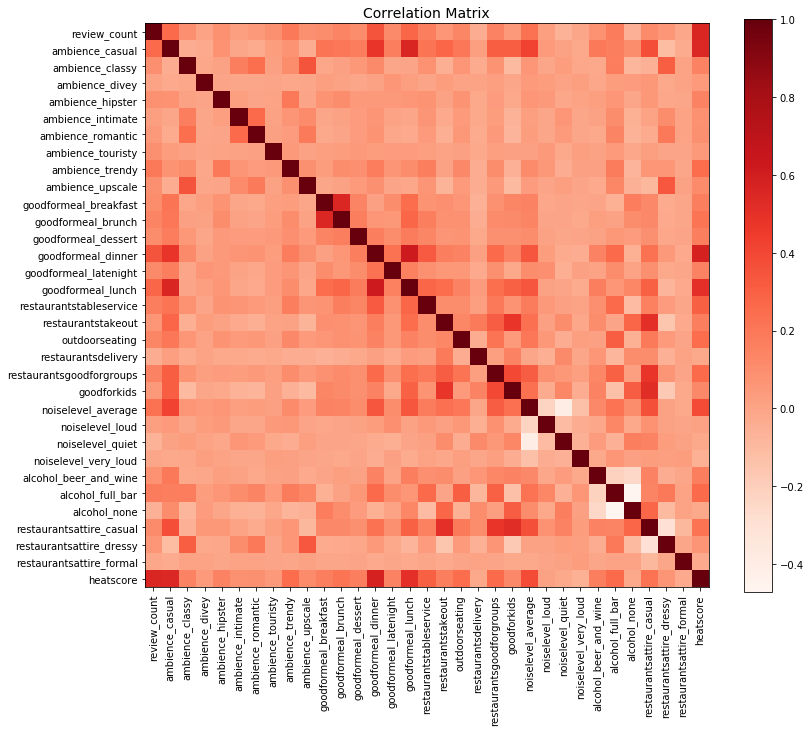

In [30]:
def plot_corr(df, target, size=12):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.drop(columns=[target]).corr()
    fig, ax = plt.subplots(figsize=(size, size))
    mat = ax.matshow(corr, cmap=plt.cm.Reds)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    ax.xaxis.set_ticks_position('bottom')
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.title("Correlation Matrix", fontsize=14, y=1)
    
    ax.figure.colorbar(mat, ax=ax, shrink=.75)
    
    plt.tight_layout()
    
    plt.show()
    
plot_corr(clean, 'stars')

Our heatscore™ feature definitely does not belong in our modeling set, since it's partially derived from our target variable.  We some of the ambience variables correlating with certain meal types, along with brunch and breakfast correlating heavily.

In [19]:
def preprocess_data(df, test_size, random_state):
    """
    Split data into feature (X) and target (y) sets, multiple target set by 2 to ensure a rounded integer, 
    scale features using standard scaler, and split again into training and testing sets.
    """
    
    # Split into feature and target sets
    X = df.drop(columns=["stars", "heatscore"])
    
    # Multiply by 2 to get integer scores over floats
    y = df["stars"] * 2
    y = y.astype(int)
    
    # Scale feature set
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Split sets for training / testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

Let's first finish up our preprocessing.  We'll first split our data into feature (X) and target (y) sets, dropping our most excellent new heatscore™ metric, as it will likely be heavily correlated to our target star rating variable.  

Next, though the star rating is an integer, it is not continuous.  Because of this, we should consider this a classification problem.  Multiplying the rating by two will give us rounded integers from 1-10, which will allow us pass them to most any classification algorithm.

Next, we'll scale our feature set (really only `review_count`, since our remaining features were all converted to binary dummy variables); and split everything into testing and training sets.

## Modeling

As a first pass, we'll use an ensemble classification model called Gradient Boost.  Ensemble methods iteratively create "weak" learning models such as a decision tree, calculate their error, and use that error inform the next iteration of the model.  This combination of stochastic gradient descent and bootstrapping (hence "Gradient Boost"!) can generate strong results with the right parameter tuning.

In [20]:
def predict_ratings(X_train, X_test, y_train, y_test, random_state):
    
    # Instantiate model
    model = GradientBoostingClassifier(subsample=0.8, min_samples_split=10, random_state=random_state)
        
    # Fit model
    model.fit(X_train, y_train)
    
    # Generate predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Score predictions
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    return train_pred, test_pred, train_score, test_score, model

In [26]:
X_train, X_test, y_train, y_test = preprocess_data(clean, 0.3, 99)
train_pred, test_pred, train_score, test_score, model = predict_ratings(X_train, X_test, y_train, y_test, 99)

print(f"Training Accuracy - {round(train_score, 2)}")
print(f"Test Accuracy - {round(test_score, 2)}")

Training Accuracy - 0.31
Test Accuracy - 0.29


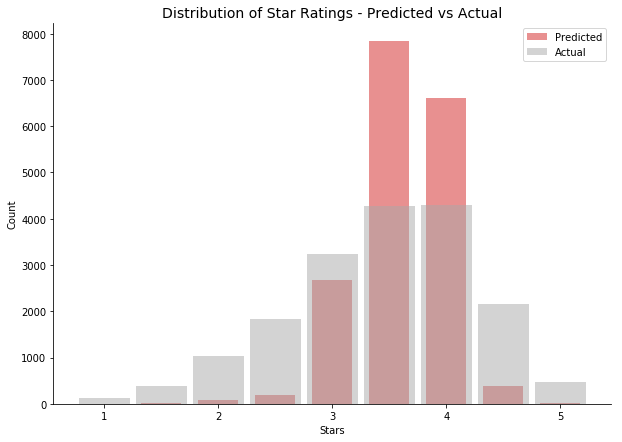

In [22]:
# Instantiate Figure
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.hist(test_pred/2, label="Predicted", alpha=0.5, rwidth=.7, color='#d32323',
        bins=[1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5], align='left')
ax.hist(y_test/2, label="Actual", alpha=0.5, rwidth=.9, color='darkgrey',
        bins=[1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5], align='left')

# Format
ax.set_title("Distribution of Star Ratings - Predicted vs Actual", fontsize=14)
ax.set_xlabel("Stars")
ax.set_ylabel("Count")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
    
plt.show()

Our initial model accurately selected the star rating 29% of the time on our test set.  This is better than random chance (10%), but still less than spectacular.  We can see in the histogram comparison, that our model overly favors 3.5 and 4 star ratings.  The edge ratings almost never received a prediction.

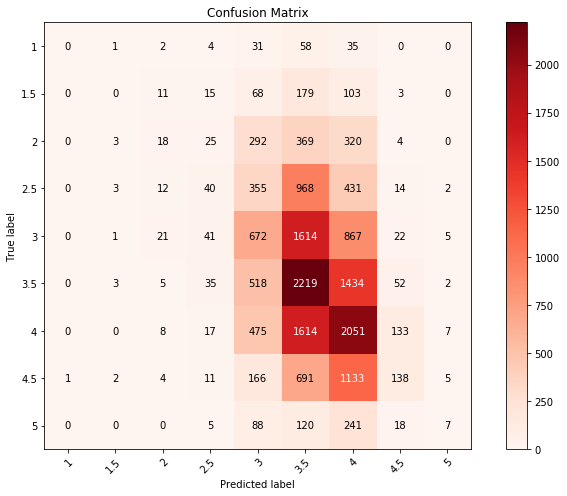

In [23]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, cmap=plt.cm.Reds):
    """
    Plots confusion matrix for input predicted and actual datasets. Normalization can be 
    applied by setting `normalize=True`.
    Adapted from:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    #sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(10, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # Format axes
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    plt.show()

stars = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

plot_confusion_matrix(y_test, test_pred, stars, normalize=False)


The confusion matrix confirms our initial observations.  The model does well predicting 3.5 and 4 star restaurants, specifically.  However, we can see most of the edge reviews get clustered into these categories, as well.

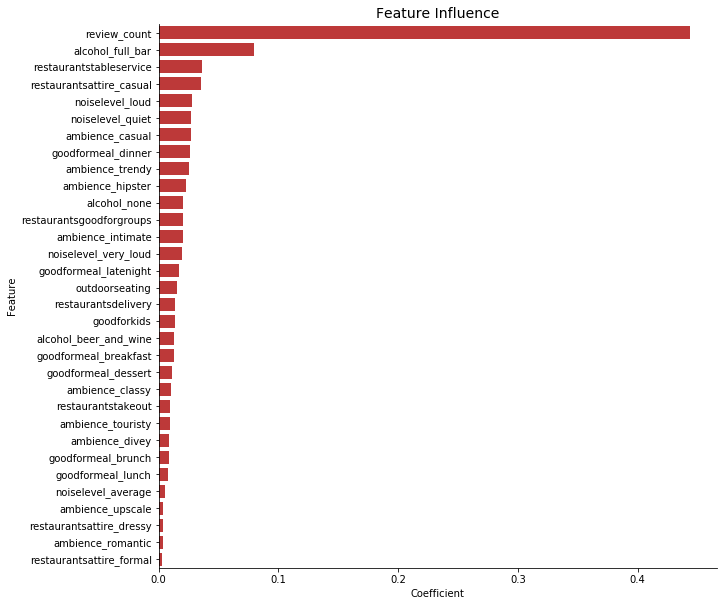

In [24]:
# Combine feature importances with feature names
cols = [x for x in clean.columns if x not in ["stars", "heatscore"]]
coefs = pd.DataFrame(zip(cols, model.feature_importances_), columns=["feature", "coefficient"]).sort_values(by="coefficient", ascending=False)

# Plot coefficients
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.barplot(x=coefs['coefficient'], y=coefs['feature'], color='#d32323', ax=ax)

# Format
ax.set_title("Feature Influence", fontsize=14)
ax.set_xlabel("Coefficient")
ax.set_ylabel("Feature")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## Steps for Improvement

Plotting the feature importance is very telling.  Review count overwhelms every other feature in our data set!  In future attemps, we might be better off excluding this feature entirely
This serves as a good baseline, but there's a lot of room for improvement.  What could our next steps be to make it more robust?

- We removed all of the geographic information in the initial cleaning of the data set.  How might we incorporate this?  Are reviewers in Québec more generous in their ratings than those in Nevada?  What if we brought in additional geographic data such as census information to tell us more about the neighborhoods these restaurants could be found in?
- We also removed the category field after using it to identify restaurants.  There are a lot of these, which might cause some issues but over-dimensionality, but perhaps there are some subcategories that flag more popular restaurants.  Maybe Arizonans are enthusiastic about barbeque in particular.
- Dimensionality reduction techniques such as principle components analysis might help us identify clusters of useful features.
- Finally, parameter tuning can be especially impactful on algorithms like gradient boost.  Grid search techniques might help us identify the optimal parameters for our model and data.

How else might we make the model more robust?

## Bonus!

Let's use our heatscore™ to find the best restaurant options in a specific city.  Las Vegas seems a good choice...

In [28]:
# Define the desired columns
cols = ["name", "categories", "address", "city", "stars", "review_count", "heatscore"]

# Apply heatscore™ to our restaurants dataset
p, q = 0.65, 100
restaurants["heatscore"] = restaurants.apply(calculate_heatscore_tm, axis=1, args=(p, q))
restaurants.sort_values(by=["heatscore"], ascending=False, inplace=True)

# Isolate Las Vegas and output the top 10
vegas = restaurants[restaurants['city'] == 'Las Vegas']
vegas.head(10)[cols]

,name,categories,address,city,stars,review_count,heatscore
business_id,,,,,,,
IhNASEZ3XnBHmuuVnWdIwA,Brew Tea Bar,"Tea Rooms, Desserts, Cafes, Restaurants, Food,...","7380 S Rainbow Blvd, Ste 101",Las Vegas,5.0,1506,6.749999
8fFTJBh0RB2EKG53ibiBKw,Zenaida's Cafe,"Cafes, Breakfast & Brunch, Restaurants","3430 E Tropicana Ave, Ste 32",Las Vegas,5.0,374,6.666861
3pSUr_cdrphurO6m1HMP9A,J Karaoke Bar,"Bars, Korean, Restaurants, Asian Fusion, Cockt...",3899 Spring Mountain Rd,Las Vegas,5.0,363,6.657193
O7UMzd3i-Zk8dMeyY9ZwoA,Art of Flavors,"Gelato, Ice Cream & Frozen Yogurt, Restaurants...","1616 S Las Vegas Blvd, Ste 130",Las Vegas,5.0,350,6.644309
cePE3rCuUOVSCCAHSjWxoQ,Karved,"Fast Food, Restaurants, Sandwiches, American (...",3957 S Maryland Pkwy,Las Vegas,5.0,313,6.596988
G4hjhtA_wQ-tSOGpgGlDjw,Bajamar Seafood & Tacos,"Dive Bars, Restaurants, Bars, Tacos, Fast Food...",1615 S Las Vegas Blvd,Las Vegas,5.0,282,6.541379
iBPyahdJRP5y0t25fF2W9w,Lip Smacking Foodie Tours,"Hotels, Food, Event Planning & Services, Hotel...",3635 Las Vegas Blvd S,Las Vegas,5.0,257,6.482126
DkYS3arLOhA8si5uUEmHOw,Earl of Sandwich,"Food Delivery Services, Salad, Sandwiches, Sou...",3667 Las Vegas Blvd S,Las Vegas,4.5,5075,6.425000
faPVqws-x-5k2CQKDNtHxw,Yardbird Southern Table & Bar,"Restaurants, American (New), Southern",3355 Las Vegas Blvd S,Las Vegas,4.5,3576,6.425000


There you have it! Brew Tea Bar is blowing every other restaurant out of the water, and it isn't even on the Strip!

#### Citations:

Bartulis, Andrius. “Algorithm to Calculate Rating Based on Multiple Reviews (Using Both Review Score and Quantity).” Mathematics Stack Exchange, [math.stackexchange.com/questions/942738/algorithm-to-calculate-rating-based-on-multiple-reviews-using-both-review-score]().

“Confusion Matrix.” Scikit, [scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py]().

“Understanding Gradient Boosting Machines.” Towards Data Science, Towards Data Science, 3 Nov. 2018, [towardsdatascience.com/understanding-gradient-boosting-machines-9be756fe76ab]().

Yelp, Inc. “Yelp Dataset.” Kaggle, 5 Feb. 2019, [www.kaggle.com/yelp-dataset/yelp-dataset]().